## Pose_Estimation

### Strategy-1: Using Coordinates as input and Lables (Correct & Incorrect)

#### Install requierd libraries

In [ ]:
'''Install requiered dependencies/libraries
-pip install numpy
-pip install opencv-python
-pip install scikit-learn
-pip install tensorflow
-pip install keras
-pip install hmmlearn
-pip install matplotlib
-pip install mediapipe ... for coordinate extracting
'''

#### Import installed and required python libraries

In [38]:
#Import requiered  installed libraries
import os
import cv2
import json
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
#from hmmlearn import hmm

### 1) Load & Process the dataset

In [62]:
# Constants
exercise = "squat"
keypoint_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [ ]:
# Process the JSON files and extract pose data
def process_json_files(data_dir):
    data = []
    labels = []

    # Iterate over the folders in the data directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip non-directory files (e.g., .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        # Determine the label based on whether it's the trainer or trainee folder
        if folder_name == "s08":
            label = "correct"
        else:
            label = "incorrect"

        # Path to the joints3d_25 folder
        joints3d_path = os.path.join(folder_path, "joints3d_25")

        # Iterate over the files in the joints3d_25 folder
        for filename in os.listdir(joints3d_path):
            if filename.endswith(".json") and filename != ".DS_Store":
                file_path = os.path.join(joints3d_path, filename)

                # Open and parse the JSON file
                with open(file_path, "r") as f:
                    json_data = json.load(f)

                # Extract skeleton coordinates for each frame
                for frame_data in json_data["joints3d_25"]:
                    pose_data = []

                    # Extract coordinates for each body part
                    for part_coords in frame_data:
                        pose_data.extend(part_coords)

                    # Append the pose data and label to the lists
                    data.append(pose_data)
                    labels.append(label)

    return data, labels


In [ ]:
# Specify the data directory
data_dir = "D:/AI/pos_estimation/train/train"

# Process the JSON files and extract pose data
data, labels = process_json_files(data_dir)

# Print the shape of the data and labels
print("Data shape:", len(data))
print("Labels shape:", len(labels))

In [64]:
# Process the JSON files and extract pose data
data, labels = process_json_files(data_dir)

In [65]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [66]:
# Define the label mapping
label_mapping = {0: "correct", 1: "incorrect"}

In [67]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

In [68]:
print("Length of X_train:", len(X_train))
print("Length of X_test:", len(X_test))

Length of X_train: 16720
Length of X_test: 4181


In [69]:
# Convert data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [70]:
# Reshape the data
X_train = tf.reshape(X_train, shape=(-1, 25, 3))
X_test = tf.reshape(X_test, shape=(-1, 25, 3))

In [71]:
# Normalize the data
X_train /= 255.0
X_test /= 255.0

In [72]:
# Print the shape of train and test data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (16720, 25, 3)
X_test shape: (4181, 25, 3)


### 2) Feature Extraction with CNN

1) Model

In [73]:
# Build the CNN model
model = tf.keras.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(25, 3)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # For labels/targets we have 2 classes: correct and incorrect
])

In [74]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 23, 32)            320       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 9, 64)             6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [75]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [76]:
# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
523/523 [==============================] - 12s 7ms/step - loss: 0.3536 - accuracy: 0.8916 - val_loss: 0.3557 - val_accuracy: 0.8852
Epoch 2/10
523/523 [==============================] - 3s 6ms/step - loss: 0.3430 - accuracy: 0.8916 - val_loss: 0.3507 - val_accuracy: 0.8852
Epoch 3/10
523/523 [==============================] - 3s 6ms/step - loss: 0.3322 - accuracy: 0.8916 - val_loss: 0.3295 - val_accuracy: 0.8852
Epoch 4/10
523/523 [==============================] - 3s 6ms/step - loss: 0.2976 - accuracy: 0.8935 - val_loss: 0.2679 - val_accuracy: 0.9003
Epoch 5/10
523/523 [==============================] - 3s 6ms/step - loss: 0.2543 - accuracy: 0.9170 - val_loss: 0.2435 - val_accuracy: 0.9294
Epoch 6/10
523/523 [==============================] - 3s 7ms/step - loss: 0.2407 - accuracy: 0.9248 - val_loss: 0.2346 - val_accuracy: 0.9294
Epoch 7/10
523/523 [==============================] - 4s 7ms/step - loss: 0.2233 - accuracy: 0.9326 - val_loss: 0.2217 - val_accuracy: 0.9321
Epoch

#### Validation parameters

In [77]:
# Calculate the average accuracy and error
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# Print the average accuracy and error
print("Average Accuracy:")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Validation Accuracy: {val_acc:.4f}")

print("Average Loss:")
print(f"  Training Loss: {train_loss:.4f}")
print(f"  Validation Loss: {val_loss:.4f}")

Average Accuracy:
  Training Accuracy: 0.9400
  Validation Accuracy: 0.9314
Average Loss:
  Training Loss: 0.1993
  Validation Loss: 0.2046


#### Plot the training results

In [78]:
# Get the training and validation metrics from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

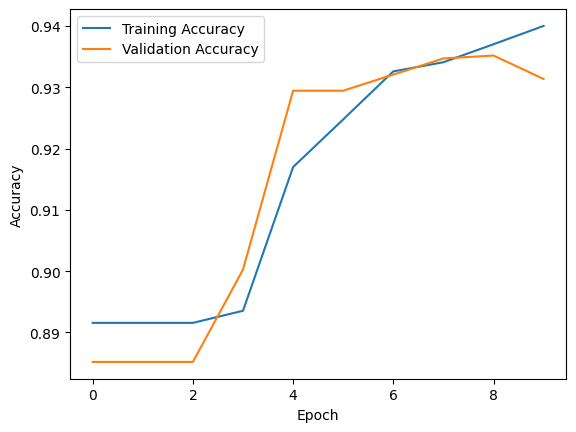

In [79]:
# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

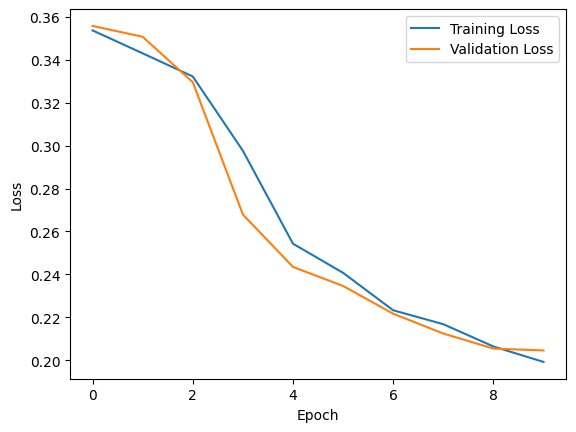

In [80]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Save the best model

In [81]:
# Specify the path to save the model
path_to_save_model = "D:/AI/pos_estimation/best_models/one"

# Save the model
model.save(path_to_save_model)

INFO:tensorflow:Assets written to: D:/AI/pos_estimation/best_models/one\assets


INFO:tensorflow:Assets written to: D:/AI/pos_estimation/best_models/one\assets


In [82]:
# Save the model to the specified file
model.save('D:/AI/pos_estimation/best_models/one/best_model.h5')

#### Test the above model

#### Coordinate extracting

In [17]:
# Coordiante extracting from landmarks using mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [ ]:
#For test Video one(s02)

# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    #r's13\videos\squat.mp4',
    r's02\videos\squat.mp4',
    #r's12\videos\squat.mp4'
]

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            if not ret:
                break
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
          
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append((x, y, z))
                coordinates.append(frame_coordinates)
            except:
                pass
            
            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
            
            cv2.imshow('Landmarks using Mediapipe', image)
        
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
    
    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'
os.makedirs(output_dir, exist_ok=True)

# Process each test video
for video in test_videos:
    video_path = os.path.join(test_folder, video)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}:".format(video))
    for frame_idx, frame_coordinates in enumerate(coordinates):
        print("Frame {}: {}".format(frame_idx, frame_coordinates))
    
    # Extract the video name and directory name
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    directory_name = os.path.basename(os.path.dirname(video_path))
    
    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, directory_name, video_name)
    os.makedirs(video_dir, exist_ok=True)
    
    # Save the coordinates as a JSON file
    json_file_path = os.path.join(video_dir, "{}_coordinates.json".format(video_name))
    if video_name == "squat":
        os.makedirs(os.path.join(video_dir, "s02"), exist_ok=True)
        json_file_path = os.path.join(video_dir, "s02", "squat_coordinates.json")
    
    with open(json_file_path, 'w') as json_file:
        json.dump(coordinates, json_file)
    
    num_frames = len(coordinates)
    print("Number of frames extracted for video {}: {}".format(video, num_frames))
    print("Coordinates saved as JSON file: {}".format(json_file_path))


In [ ]:
#For test Video two(s12)

# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    #r's13\videos\squat.mp4',
    #r's02\videos\squat.mp4',
    r's12\videos\squat.mp4'
]

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            if not ret:
                break
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
          
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append((x, y, z))
                coordinates.append(frame_coordinates)
            except:
                pass
            
            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
            
            cv2.imshow('Landmarks using Mediapipe', image)
        
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
    
    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'
os.makedirs(output_dir, exist_ok=True)

# Process each test video
for video in test_videos:
    video_path = os.path.join(test_folder, video)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}:".format(video))
    for frame_idx, frame_coordinates in enumerate(coordinates):
        print("Frame {}: {}".format(frame_idx, frame_coordinates))
    
    # Extract the video name and directory name
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    directory_name = os.path.basename(os.path.dirname(video_path))
    
    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, directory_name, video_name)
    os.makedirs(video_dir, exist_ok=True)
    
    # Save the coordinates as a JSON file
    json_file_path = os.path.join(video_dir, "{}_coordinates.json".format(video_name))
    if video_name == "squat":
        os.makedirs(os.path.join(video_dir, "s12"), exist_ok=True)
        json_file_path = os.path.join(video_dir, "s12", "squat_coordinates.json")
    
    with open(json_file_path, 'w') as json_file:
        json.dump(coordinates, json_file)
    
    num_frames = len(coordinates)
    print("Number of frames extracted for video {}: {}".format(video, num_frames))
    print("Coordinates saved as JSON file: {}".format(json_file_path))


In [ ]:
#For test Video three(s13)

# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    r's13\videos\squat.mp4',
    #r's02\videos\squat.mp4',
    #r's12\videos\squat.mp4'
]

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            if not ret:
                break
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
          
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append((x, y, z))
                coordinates.append(frame_coordinates)
            except:
                pass
            
            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
            
            cv2.imshow('Landmarks using Mediapipe', image)
        
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
    
    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'
os.makedirs(output_dir, exist_ok=True)

# Process each test video
for video in test_videos:
    video_path = os.path.join(test_folder, video)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}:".format(video))
    for frame_idx, frame_coordinates in enumerate(coordinates):
        print("Frame {}: {}".format(frame_idx, frame_coordinates))
    
    # Extract the video name and directory name
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    directory_name = os.path.basename(os.path.dirname(video_path))
    
    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, directory_name, video_name)
    os.makedirs(video_dir, exist_ok=True)
    
    # Save the coordinates as a JSON file
    json_file_path = os.path.join(video_dir, "{}_coordinates.json".format(video_name))
    if video_name == "squat":
        os.makedirs(os.path.join(video_dir, "s13"), exist_ok=True)
        json_file_path = os.path.join(video_dir, "s13", "squat_coordinates.json")
    
    with open(json_file_path, 'w') as json_file:
        json.dump(coordinates, json_file)
    
    num_frames = len(coordinates)
    print("Number of frames extracted for video {}: {}".format(video, num_frames))
    print("Coordinates saved as JSON file: {}".format(json_file_path))


#### For whole three video coordinate extraction

In [ ]:
# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    {'directory': 's13', 'filename': 'squat.mp4'},
    {'directory': 's02', 'filename': 'squat.mp4'},
    {'directory': 's12', 'filename': 'squat.mp4'}
]

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append((x, y, z))
                coordinates.append(frame_coordinates)
            except:
                pass

            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'

# Process each test video
for video in test_videos:
    video_directory = video['directory']
    video_filename = video['filename']
    video_path = os.path.join(test_folder, video_directory, 'videos', video_filename)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}: {}".format(video_directory, coordinates))

    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, 'squat', video_directory)
    os.makedirs(video_dir, exist_ok=True)

    # Save the coordinates as a JSON file
    output_file = os.path.join(video_dir, 'squat_coordinates.json')
    with open(output_file, 'w') as f:
        json.dump(coordinates, f)

    print("Saved coordinates for video {} to {}".format(video_directory, output_file))


In [ ]:
# Function to calculate angle between three points
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Mid point
    c = np.array(c)  # End point
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    {'directory': 's13', 'filename': 'squat.mp4'},
    {'directory': 's02', 'filename': 'squat.mp4'},
    {'directory': 's12', 'filename': 'squat.mp4'}
]

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append((x, y, z))
                coordinates.append(frame_coordinates)
                
                # Calculate angle using the three coordinate points
                if len(frame_coordinates) >= 3:
                    a, b, c = frame_coordinates[-3:]
                    angle = calculate_angle(a, b, c)
                    print("Angle:", angle)
            except:
                pass

            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'

# Process each test video
for video in test_videos:
    video_directory = video['directory']
    video_filename = video['filename']
    video_path = os.path.join(test_folder, video_directory, 'videos', video_filename)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}: {}".format(video_directory, coordinates))

    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, 'squat', video_directory)
    os.makedirs(video_dir, exist_ok=True)

    # Save the coordinates as a JSON file
    output_file = os.path.join(video_dir, 'squat_coordinates.json')
    with open(output_file, 'w') as f:
        json.dump(coordinates, f)

    print("Saved coordinates for video {} to {}".format(video_directory, output_file))


#### Calculate the angle

In [ ]:
# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Function to calculate the angle between three points
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Mid point
    c = np.array(c)  # End point

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append((x, y, z))
                coordinates.append(frame_coordinates)
            except:
                pass

            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(
                image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'

# Process each test video
for video in test_videos:
    video_directory = video['directory']
    video_filename = video['filename']
    video_path = os.path.join(test_folder, video_directory, 'videos', video_filename)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}: {}".format(video_directory, coordinates))

    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, 'squat', video_directory)
    os.makedirs(video_dir, exist_ok=True)

    # Save the coordinates as a JSON file
    output_file = os.path.join(video_dir, 'squat_coordinates.json')
    with open(output_file, 'w') as f:
        json.dump(coordinates, f)

    print("Saved coordinates for video {} to {}".format(video_directory, output_file))

    # Calculate angles
    angles = []
    for frame_coordinates in coordinates:
        if len(frame_coordinates) >= 3:
            a, b, c = frame_coordinates[-3:]
            angle = calculate_angle(a, b, c)
            angles.append(angle)

    # Save the angles as a CSV file in the same directory
    angles_file = os.path.join(video_dir, 'angles.csv')
    with open(angles_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Frame', 'Angle'])
        for i, angle in enumerate(angles):
            writer.writerow([i+1, angle])

    print("Saved angles for video {} to {}".format(video_directory, angles_file))


### Test the model

##### Notice that:
- 0 : INCORRECT
- 1 : CORRECT

In [93]:
# Test-1:

model = keras.models.load_model(r'D:\AI\pos_estimation\best_models\one\best_model.h5')
with open(r'D:\AI\pos_estimation\test_coordinates\squat\s13\squat_coordinates.json') as file:
    data = json.load(file)

# Extract the coordinates from the loaded JSON data
coordinates = np.array(data)  # No need for data['coordinates']
predictions = model.predict(coordinates)
predicted_labels = np.argmax(predictions, axis=1)

label_mapping = {0: 'correct', 1: 'incorrect'}
interpreted_labels = [label_mapping[label] for label in predicted_labels]
# Print the interpreted labels
print(interpreted_labels)


46/46 [==============================] - 0s 3ms/step
['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 

In [116]:
import json
import numpy as np

model = keras.models.load_model(r'D:\AI\pos_estimation\best_models\one\best_model.h5')
with open(r'D:\AI\pos_estimation\test_coordinates\squat\s13\squat_coordinates.json') as file:
    data = json.load(file)

# Extract the coordinates from the loaded JSON data
coordinates = np.array(data)  # No need for data['coordinates']
predictions = model.predict(coordinates)

# Extract the x, y, and z predictions
x_predictions = predictions[:, 0]  # Assuming the first element represents the x coordinate
y_predictions = predictions[:, 1]  # Assuming the second element represents the y coordinate
z_predictions = predictions[:, 2]  # Assuming the third element represents the z coordinate

# Format the predictions to 3 decimal points
formatted_x_predictions = np.round(x_predictions, decimals=3)
formatted_y_predictions = np.round(y_predictions, decimals=3)
formatted_z_predictions = np.round(z_predictions, decimals=3)

# Create a dictionary to store the predictions
predicted_coordinates = {
    'x': formatted_x_predictions.tolist(),
    'y': formatted_y_predictions.tolist(),
    'z': formatted_z_predictions.tolist()
}

# Save the predicted coordinates to a JSON file
output_file = r'D:\AI\pos_estimation\predicted_coordinates.json'
with open(output_file, 'w') as file:
    json.dump(predicted_coordinates, file)

# Print the saved coordinates
print("Predicted coordinates saved to:", output_file)


46/46 [==============================] - 0s 4ms/step


IndexError: index 2 is out of bounds for axis 1 with size 2

### Other model

In [31]:
# Constants
exercise = "squat"
keypoint_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Process the JSON files and extract pose data
def process_json_files(data_dir):
    data = []
    labels = []

    # Iterate over the folders in the data directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip non-directory files (e.g., .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        # Determine the label based on whether it's the trainer or trainee folder
        if folder_name == "s08":
            label = "correct"
        else:
            label = "incorrect"

        # Path to the joints3d_25 folder
        joints3d_path = os.path.join(folder_path, "joints3d_25")

        # Iterate over the files in the joints3d_25 folder
        for filename in os.listdir(joints3d_path):
            if filename.endswith(".json") and filename != ".DS_Store":
                file_path = os.path.join(joints3d_path, filename)

                # Open and parse the JSON file
                with open(file_path, "r") as f:
                    json_data = json.load(f)

                # Extract skeleton coordinates for each frame
                for frame_data in json_data["joints3d_25"]:
                    pose_data = []

                    # Extract coordinates for each body part
                    for index in keypoint_indices:
                        part_coords = frame_data[index]
                        pose_data.extend(part_coords)

                    # Append the pose data and label to the lists
                    data.append(pose_data)
                    labels.append(label)

    return data, labels

# Specify the data directory
data_dir = "D:/AI/pos_estimation/train/train"

# Process the JSON files and extract pose data
data, labels = process_json_files(data_dir)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Convert data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Reshape the data
X_train = tf.reshape(X_train, shape=(-1, 25, 3))
X_test = tf.reshape(X_test, shape=(-1, 25, 3))

# Normalize the data
X_train /= 255.0
X_test /= 255.0

# CNN Model
cnn_model = tf.keras.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(25, 3)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: correct, incorrect, almost correct
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
523/523 [==============================] - 6s 7ms/step - loss: 0.3732 - accuracy: 0.8902 - val_loss: 0.3576 - val_accuracy: 0.8852
Epoch 2/10
523/523 [==============================] - 3s 6ms/step - loss: 0.3432 - accuracy: 0.8916 - val_loss: 0.3549 - val_accuracy: 0.8852
Epoch 3/10
523/523 [==============================] - 3s 5ms/step - loss: 0.3372 - accuracy: 0.8916 - val_loss: 0.3566 - val_accuracy: 0.8852
Epoch 4/10
523/523 [==============================] - 3s 5ms/step - loss: 0.3026 - accuracy: 0.8942 - val_loss: 0.2673 - val_accuracy: 0.8974
Epoch 5/10
523/523 [==============================] - 3s 7ms/step - loss: 0.2489 - accuracy: 0.9233 - val_loss: 0.2436 - val_accuracy: 0.9273
Epoch 6/10
523/523 [==============================] - 3s 5ms/step - loss: 0.2315 - accuracy: 0.9294 - val_loss: 0.2299 - val_accuracy: 0.9323
Epoch 7/10
523/523 [==============================] - 3s 5ms/step - loss: 0.2204 - accuracy: 0.9328 - val_loss: 0.2219 - val_accuracy: 0.9357
Epoch 

                                        **********************************

#### Try-2

In [19]:
# Extract features from the trained CNN model
train_features = cnn_model.predict(X_train)
test_features = cnn_model.predict(X_test)

# Organize features into sequences for each repetition of the exercise
exercise_sequences_train = []
exercise_sequences_test = []

# Create sequence for training set
current_sequence = []
current_label = y_train[0]
for i in range(len(train_features)):
    if y_train[i] == current_label:
        current_sequence.append(train_features[i])
    else:
        exercise_sequences_train.append(current_sequence)
        current_sequence = [train_features[i]]
        current_label = y_train[i]
exercise_sequences_train.append(current_sequence)

# Create sequence for test set
current_sequence = []
current_label = y_test[0]
for i in range(len(test_features)):
    if y_test[i] == current_label:
        current_sequence.append(test_features[i])
    else:
        exercise_sequences_test.append(current_sequence)
        current_sequence = [test_features[i]]
        current_label = y_test[i]
exercise_sequences_test.append(current_sequence)

# Train an HMM model on the feature sequences
num_states = 3  # Specify the desired number of HMM states

hmm_model = hmm.GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=100)
for sequence in exercise_sequences_train:
    hmm_model.fit(sequence)

# Evaluate the trained HMM model on the test set and calculate performance metrics
predicted_labels = []
for sequence in exercise_sequences_test:
    sequence_likelihoods = []
    for state in range(num_states):
        log_likelihood = hmm_model.score(sequence)
        sequence_likelihoods.append(log_likelihood)
    predicted_label = np.argmax(sequence_likelihoods)
    predicted_labels.append(predicted_label)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)


131/131 [==============================] - 1s 5ms/step


Model is not converging.  Current: 55.6733104794739 is not greater than 62.73782106764467. Delta is -7.064510588170769
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 26 free scalar parameters with only 3 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


ValueError: n_samples=1 should be >= n_clusters=3.

#### Try-3

### Other CNN models with Fine-tuned

In [98]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(25, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [99]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [100]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
523/523 [==============================] - 4s 4ms/step - loss: 0.3552 - accuracy: 0.8916 - val_loss: 0.3567 - val_accuracy: 0.8852
Epoch 2/10
523/523 [==============================] - 2s 4ms/step - loss: 0.3409 - accuracy: 0.8916 - val_loss: 0.3579 - val_accuracy: 0.8852
Epoch 3/10
523/523 [==============================] - 2s 4ms/step - loss: 0.3378 - accuracy: 0.8916 - val_loss: 0.3473 - val_accuracy: 0.8852
Epoch 4/10
523/523 [==============================] - 2s 4ms/step - loss: 0.3222 - accuracy: 0.8916 - val_loss: 0.3374 - val_accuracy: 0.8852
Epoch 5/10
523/523 [==============================] - 2s 5ms/step - loss: 0.2931 - accuracy: 0.8923 - val_loss: 0.2857 - val_accuracy: 0.8936
Epoch 6/10
523/523 [==============================] - 3s 5ms/step - loss: 0.2630 - accuracy: 0.9047 - val_loss: 0.2581 - val_accuracy: 0.9187
Epoch 7/10
523/523 [==============================] - 3s 5ms/step - loss: 0.2480 - accuracy: 0.9219 - val_loss: 0.2769 - val_accuracy: 0.8981
Epoch 

#### Fine-tune the CNN to optimize its performance on pose classification

In [94]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(25, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [95]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [96]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [97]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
523/523 [==============================] - 5s 6ms/step - loss: 0.3538 - accuracy: 0.8904 - val_loss: 0.3601 - val_accuracy: 0.8852
Epoch 2/20
523/523 [==============================] - 3s 5ms/step - loss: 0.3408 - accuracy: 0.8916 - val_loss: 0.3488 - val_accuracy: 0.8852
Epoch 3/20
523/523 [==============================] - 3s 5ms/step - loss: 0.3205 - accuracy: 0.8916 - val_loss: 0.3052 - val_accuracy: 0.8852
Epoch 4/20
523/523 [==============================] - 3s 5ms/step - loss: 0.2616 - accuracy: 0.9131 - val_loss: 0.2459 - val_accuracy: 0.9259
Epoch 5/20
523/523 [==============================] - 3s 6ms/step - loss: 0.2426 - accuracy: 0.9242 - val_loss: 0.2313 - val_accuracy: 0.9314
Epoch 6/20
523/523 [==============================] - 3s 6ms/step - loss: 0.2269 - accuracy: 0.9304 - val_loss: 0.2267 - val_accuracy: 0.9318
Epoch 7/20
523/523 [==============================] - 4s 7ms/step - loss: 0.2123 - accuracy: 0.9363 - val_loss: 0.2058 - val_accuracy: 0.9359
Epoch 

2

In [50]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the CNN model
def build_cnn_model(input_shape):
    model = tf.keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

    return model

# Specify the input shape based on your data
input_shape = (25, 3)  # Assuming each sequence has 25 frames with 3 coordinates (x, y, z)

# Build the CNN model
model = build_cnn_model(input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 23, 32)            320       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 11, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 9, 64)             6208      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 2, 128)            24704     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 128)          

In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_val, y_val)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

